In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [22]:
file = "./tc1.csv"
data = pd.read_csv(file)



TCPdata = data[data["Protocol"]=="TCP"]


Part 1

In [30]:

SYNdata = TCPdata[TCPdata["Info"].str.contains("\[SYN\]")]
SYNdataDest = SYNdata[TCPdata["Info"].str.contains(">  21")]
SYNdataSrc = SYNdata[TCPdata["Info"].str.contains("21  >")]   #dont take this one
UniqueServer = set(SYNdataSrc["Source"].unique().tolist()) | set(SYNdataDest["Destination"].unique().tolist())
len(UniqueServer)

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


45

Part 2

In [24]:
# data["SrcPort"] = data["Info"][data["Info"].str.extract(pat = '(\d+)  >  (\d+)')
tempList = TCPdata["Info"].tolist()
srcList = [string[:string.find("[")].strip().split('  >  ')[0] for string in tempList]
destList = [string[:string.find("[")].strip().split('  >  ')[1] for string in tempList]
srcList, destList
TCPdata["SrcPort"] = srcList
TCPdata["DestPort"] = destList
uniqueTCPflows = TCPdata.drop_duplicates(subset = ["Source", "Destination", "SrcPort", "DestPort"])
len(uniqueTCPflows)


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


3256

Part 3

<BarContainer object of 24 artists>

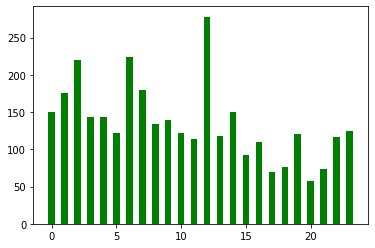

In [25]:
TCPfrequency = {}
for i in range(24):
    TCPfrequency[i] = 0
    
timeList = uniqueTCPflows["Time"].tolist()
timeList = [int(time // 3600) for time in timeList]
for time in timeList:
    TCPfrequency[time] += 1
TCPfrequency

plt.bar(TCPfrequency.keys(), TCPfrequency.values(), 0.5, color='g')

Part 4

In [26]:
SYNdata = TCPdata[TCPdata["Info"].str.contains("\[SYN\]")]# | TCPdata["Info"].str.contains("\[FIN\]")]
FINdata = TCPdata[TCPdata["Info"].str.contains("\[FIN, ACK\]")]# | TCPdata["Info"].str.contains("\[FIN\]")]
RSTdata = TCPdata[TCPdata["Info"].str.contains("\[RST\]")]# | TCPdata["Info"].str.contains("\[FIN\]")]



SYNdata


,No.,Time,Source,Destination,Protocol,Length,Info,SrcPort,DestPort
0,1,0.000000,142.164.6.70,131.243.1.10,TCP,62,1313 > 21 [SYN] Seq=1734984547 Win=8760 Len=...,1313,21
2,3,2.962409,142.164.6.70,131.243.1.10,TCP,62,1313 > 21 [SYN] Seq=1734984547 Win=8760 Len...,1313,21
90,91,105.078090,73.6.91.115,131.243.2.12,TCP,62,2027 > 21 [SYN] Seq=4190971401 Win=16384 Len...,2027,21
399,400,222.785014,82.143.24.12,131.243.2.12,TCP,62,3537 > 21 [SYN] Seq=2986625670 Win=16384 Len...,3537,21
484,485,251.651531,79.37.53.67,131.243.2.12,TCP,62,35280 > 21 [SYN] Seq=4133316359 Win=16384 Le...,35280,21
...,...,...,...,...,...,...,...,...,...
282181,282182,86279.993769,31.240.144.130,131.243.1.10,TCP,74,2532 > 21 [SYN] Seq=3644838796 Win=32120 Len...,2532,21
282255,282256,86288.175093,230.101.18.175,128.3.12.44,TCP,74,4860 > 21 [SYN] Seq=1619430015 Win=57344 Len...,4860,21
282334,282335,86303.061396,31.240.144.130,131.243.1.10,TCP,74,2534 > 21 [SYN] Seq=3662021497 Win=32120 Len...,2534,21
282511,282512,86335.871825,224.65.194.147,203.174.5.11,TCP,62,63210 > 21 [SYN] Seq=521097895 Win=16384 Len...,63210,21


In [27]:
FINdata

,No.,Time,Source,Destination,Protocol,Length,Info,SrcPort,DestPort
369,370,206.338153,142.164.6.70,131.243.1.10,TCP,54,"1313 > 21 [FIN, ACK] Seq=1734985255 Ack=1166...",1313,21
371,372,206.339715,131.243.1.10,142.164.6.70,TCP,54,"21 > 1313 [FIN, ACK] Seq=1166105771 Ack=1734...",21,1313
559,560,264.765366,79.37.53.67,131.243.2.12,TCP,54,"35280 > 21 [FIN, ACK] Seq=4133316713 Ack=38...",35280,21
569,570,266.648644,82.143.24.12,131.243.2.12,TCP,54,"3537 > 21 [FIN, ACK] Seq=2986625964 Ack=3800...",3537,21
891,892,387.261038,67.243.63.146,131.243.1.10,TCP,54,"1383 > 21 [FIN, ACK] Seq=3857592 Ack=2199040...",1383,21
...,...,...,...,...,...,...,...,...,...
282411,282412,86308.233196,31.240.144.130,131.243.1.10,TCP,54,"2534 > 21 [FIN, ACK] Seq=3662021644 Ack=2655...",2534,21
282544,282545,86337.768818,224.65.194.147,203.174.5.11,TCP,54,"63210 > 21 [FIN, ACK] Seq=521098027 Ack=1319...",63210,21
282547,282548,86337.772973,203.174.5.11,224.65.194.147,TCP,54,"21 > 63210 [FIN, ACK] Seq=131904522 Ack=5210...",21,63210
282567,282568,86345.139448,131.243.1.10,132.34.219.22,TCP,54,"21 > 1166 [FIN, ACK] Seq=201550085 Ack=50934...",21,1166


In [28]:
RSTdata

,No.,Time,Source,Destination,Protocol,Length,Info,SrcPort,DestPort
563,564,264.944710,79.37.53.67,131.243.2.12,TCP,54,35280 > 21 [RST] Seq=4133316714 Win=0 Len=0,35280,21
571,572,266.828165,82.143.24.12,131.243.2.12,TCP,54,3537 > 21 [RST] Seq=2986625965 Win=0 Len=0,3537,21
572,573,266.829593,82.143.24.12,131.243.2.12,TCP,54,3537 > 21 [RST] Seq=2986625965 Win=0 Len=0,3537,21
1228,1229,424.013972,67.243.63.146,131.243.1.10,TCP,54,1385 > 21 [RST] Seq=3863962 Win=0 Len=0,1385,21
1229,1230,424.014011,67.243.63.146,131.243.1.10,TCP,54,1390 > 21 [RST] Seq=3891210 Win=0 Len=0,1390,21
...,...,...,...,...,...,...,...,...,...
282157,282158,86270.011319,189.89.200.219,131.243.1.10,TCP,54,63780 > 21 [RST] Seq=61005765 Win=0 Len=0,63780,21
282158,282159,86270.012052,189.89.200.219,131.243.1.10,TCP,54,63780 > 21 [RST] Seq=61005765 Win=0 Len=0,63780,21
282548,282549,86337.812985,224.65.194.147,203.174.5.11,TCP,54,63210 > 21 [RST] Seq=521098028 Win=0 Len=0,63210,21
282549,282550,86337.817255,224.65.194.147,203.174.5.11,TCP,54,63210 > 21 [RST] Seq=521098028 Win=0 Len=0,63210,21


In [9]:
timeList = []
for i in range(5):
    startTime = SYNdata.iloc[i,1]
    Src = SYNdata.iloc[i,2]
    Dest = SYNdata.iloc[i,3]
    SrcPort = SYNdata.iloc[i,7]
    DestPort = SYNdata.iloc[i,8]


    validFIN1 = FINdata[(FINdata["Source"] == Src) & (FINdata["Destination"] == Dest) & (FINdata["SrcPort"] == SrcPort) & (FINdata["DestPort"] == DestPort) & (FINdata["Time"]>startTime)]
    validFIN2 = FINdata[(FINdata["Source"] == Dest) & (FINdata["Destination"] == Src) & (FINdata["SrcPort"] == DestPort) & (FINdata["DestPort"] == SrcPort) & (FINdata["Time"]>startTime)]
    validRST1 = RSTdata[(RSTdata["Source"] == Src) & (RSTdata["Destination"] == Dest) & (RSTdata["SrcPort"] == SrcPort) & (RSTdata["DestPort"] == DestPort) & (RSTdata["Time"]>startTime)]
    validRST2 = RSTdata[(RSTdata["Source"] == Dest) & (RSTdata["Destination"] == Src) & (RSTdata["SrcPort"] == DestPort) & (RSTdata["DestPort"] == SrcPort) & (RSTdata["Time"]>startTime)]
    
    validFrames =  pd.concat([validFIN1, validFIN2, validRST1, validRST2])

    print(SYNdata.iloc[i])
    print(validFrames)

    



No.                                                            1
Time                                                           0
Source                                              142.164.6.70
Destination                                         131.243.1.10
Protocol                                                     TCP
Length                                                        62
Info           1313  >  21 [SYN] Seq=1734984547 Win=8760 Len=...
SrcPort                                                     1313
DestPort                                                      21
Name: 0, dtype: object
     No.        Time        Source   Destination Protocol  Length  \
369  370  206.338153  142.164.6.70  131.243.1.10      TCP      54   
371  372  206.339715  131.243.1.10  142.164.6.70      TCP      54   

                                                  Info SrcPort DestPort  
369  1313  >  21 [FIN, ACK] Seq=1734985255 Ack=1166...    1313       21  
371  21  >  1313 [FIN, ACK] Seq=1166